In [4]:
%matplotlib inline

from __future__ import division

from faculty_hiring.misc.util import *
from faculty_hiring.misc.plotting import *  # Definitions for LABEL_SIZE and such
from faculty_hiring.misc.productivity import *
from faculty_hiring.parse import faculty_parser, institution_parser
from faculty_hiring.parse import load
from faculty_hiring.parse.nces import parse_phds_awarded
from faculty_hiring.misc.subfield import topic_descriptions, longer_topic_descriptions, num_topics 

from sklearn import linear_model
from collections import Counter
from fuzzywuzzy import fuzz
from random import choice
import statsmodels.api as sm
import numpy as np
import scipy as sp
import pandas as pd

sig_level = 0.05

# File locations
faculty_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/faculty_cs_CURRENT.txt'
inst_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/inst_cs_CURRENT.txt'
figures_dir = '/Users/allisonmorgan/Code/src/github.com/samfway/faculty_hiring/notebooks-productivity/figures/'
#nces_table = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/data/nces_table.txt'

# (Optional, these are for loading publication profiles)
dblp_dir = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/profiles_DBLP_Nov16/'

In [5]:
inst = institution_parser.parse_institution_records(open(inst_file))
asst_faculty = load.load_assistant_profs(open(faculty_file), inst, ranking='pi')
ignore = ['All others', 'UNKNOWN', 'CUNY Graduate Center']
inst_keys = [place for place in inst if place not in ignore]
inst_keys = [s[1] for s in sorted([(inst[place]['pi'], place) for place in inst_keys])]
inst_keys_top = inst_keys[:99]

load.load_all_publications(asst_faculty, dblp_dir)

## Profile the Schools

Pre-compute all information that we'll need in order to match pairs of schools

In [6]:
# Number of publications for all current assistant faculty of a university. Adjusted for inflation
pubs_by_inst = {}
for (name, inst_data) in inst.items():
    if name in ignore:
        continue
    current_faculty = faculty_at_institution(name, asst_faculty)
    n_pubs = []
    for person in current_faculty:
        if person.__contains__('dblp_pubs'):
            contribution = 0
            for pub in person.dblp_pubs:
                contribution += inflation_adjust(pub['year'])
            n_pubs.append(contribution)
    if len(n_pubs) > 0:
        pubs_by_inst[name] = {"total_pubs_by_author": n_pubs, "status": inst_data['private'], "rank": inst_data['pi']} 

## Match 'em

In [7]:
# How many private schools are there? How many public schools are there?
public = [name for (name, data) in pubs_by_inst.items() if data['status'] == 0]
private = [name for (name, data) in pubs_by_inst.items() if data['status'] == 1]

In [8]:
print("We will undersample our %d public schools, since we are limited by %d private schools" % (len(public), len(private)))

We will undersample our 151 public schools, since we are limited by 53 private schools


In [16]:
def return_profiles(pubs_by_inst, public, private):
    profiles = np.zeros((len(private)*2, 3), dtype=np.float)

    index = 0
    for i, inst in enumerate([pubs_by_inst[name] for name in private]):
        profiles[i,0] = np.average(inst['total_pubs_by_author'])
        profiles[i,1] = float(inst['status'])
        profiles[i,2] = inst['rank']   
        index = i
    
    for j, inst in enumerate([pubs_by_inst[name] for name in public[:len(private)]]):
        profiles[index + j,0] = np.average(inst['total_pubs_by_author'])
        profiles[index + j,1] = float(inst['status'])
        profiles[index + j,2] = inst['rank']
    
    return profiles

In [18]:
profiles = return_profiles(pubs_by_inst, public, private)
print(len(profiles), profiles[0])

(106, array([ 142.54143551,    1.        ,   21.92      ]))


In [19]:
def get_matched_pairs(P, skip=0.0):
    pairs = []
    scores = []
    num_available = P.shape[0]
    available = np.ones(num_available)
    print_after = -1
    i = 0
    
    possible_matches = np.floor(0.5*num_available)
    grab = (1-skip)*possible_matches
    num_matches = 0
    
    while num_available > 2:
        p1 = np.random.choice(np.where(available)[0])
        p2 = -1
        best_score = np.inf
        
        for ptemp, is_available in enumerate(available):
            # Only consider schools with different public/private status: P[p1,1]
            if is_available and p1 != ptemp and P[p1,1] != P[ptemp,1]:
                # Only match on rank. Disregard total pubs and status when comparing
                score = np.linalg.norm(P[p1,2] - P[ptemp,2]) # + np.random.random() ########
                if score < best_score:
                    p2 = ptemp
                    best_score = score
            
        i += 1
        if i == print_after:
            i = 0
            print num_available
        
                
        available[p1] = 0
        available[p2] = 0
        pairs.append((p1, p2))
        scores.append(best_score)
        num_available -= 2
        num_matches += 1
        
        if num_matches > grab:
            break

        
    if num_available == 2:
        p1, p2 = np.where(available)[0]
        pairs.append((p1, p2))
        score = np.linalg.norm(P[p1,2] - P[p2,2])
        scores.append(score)
                
    return pairs, scores

In [52]:
pairs,_ = get_matched_pairs(profiles, skip=0.9)
for p1, p2 in pairs:
    if p1 % len(private) == p1:
        name1 = private[p1]
        name2 = public[(p2 % len(private))]
    else:
        name1 = public[(p1 % len(private))]
        name2 = private[p2]
        
    print '%s (%s)\t<-->\t%s (%s)' % (name1, 
                                    "Private" if profiles[p1, 1] else "Public", 
                                    name2, 
                                    "Private" if profiles[p2, 1] else "Public")

Portland State University (Public)	<-->	Colorado School of Mines (Private)
Carnegie Mellon University (Private)	<-->	McMaster University (Public)
Temple University (Public)	<-->	Worcester Polytechnic Institute (Private)
University of Notre Dame (Private)	<-->	University of North Carolina, Chapel Hill (Public)
University of Arkansas, Fayetteville (Public)	<-->	Vanderbilt University (Private)
Northwestern University (Private)	<-->	Clemson University (Public)


In [55]:
total_trials = 0
num_positive = 0
advantages = []

for time in xrange(5000):
    # Shuffle the public schools selected, so we aren't systematically undersampling some public schools.
    np.random.shuffle(public)
    profiles = return_profiles(pubs_by_inst, public, private)
    
    pairs,_ = get_matched_pairs(profiles, skip=0.0)
    for p1, p2 in pairs:
        # Who published more? Was this a private university?
        private_university = np.argmax([profiles[p1,1], profiles[p2,1]])
        published_more = np.argmax([profiles[p1,0], profiles[p2,0]])
        if private_university == published_more:
            num_positive += 1
            advantages.append(np.abs(profiles[p1,0] - profiles[p2,0]))
        total_trials += 1
    
print sp.stats.binom_test(num_positive, total_trials, .5, alternative='greater')

6.43082144885e-139


In [61]:
print num_positive, total_trials
float(num_positive) / total_trials

138950 265000


0.5243396226415095

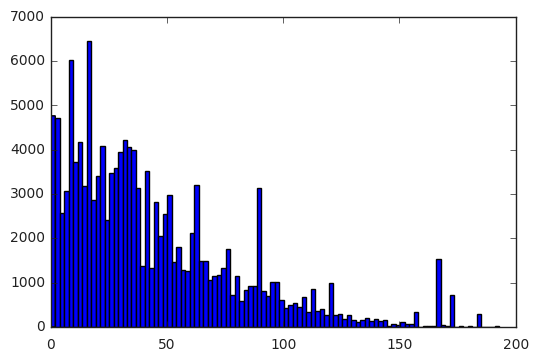

In [62]:
plt.hist(advantages, bins=100)
plt.show()

In [63]:
np.mean(advantages)

44.297632918685139

In [64]:
np.median(advantages)

34.505149636201764

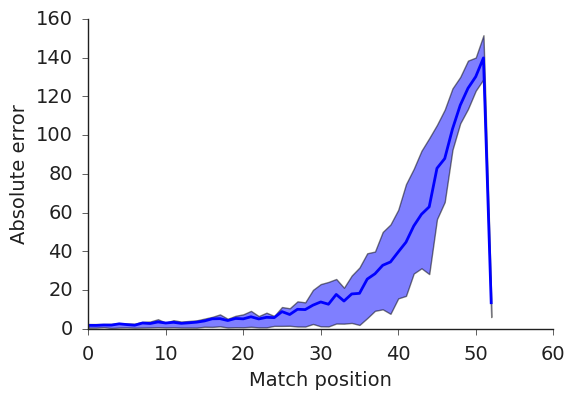

In [65]:
T = 100
num_matches = len(pairs)
scores = np.zeros((T, num_matches), dtype=float)

for t in xrange(T):
    _,s = get_matched_pairs(profiles)
    scores[t, :] = np.array(s)

fig, ax = plt.subplots(1,1,figsize=SINGLE_FIG_SIZE)
ylo = np.percentile(scores, 25, axis=0)
yhi = np.percentile(scores, 75, axis=0)
ax.fill_between(xrange(len(ylo)), ylo, yhi, alpha=0.5)
ax.plot(np.mean(scores, axis=0), lw=LINE_WIDTH)

ax.set_xlabel('Match position')
ax.set_ylabel('Absolute error')
finalize(ax)
plt.show()